In [2]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Use S&P 500 and Markov Autoregressive Model to identify high-vol and low-vol market regimes

<ipython-input-79-aca8e7c47586>:5: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  SPX_rtn=(np.divide(SPX[1:], SPX[:-1]) - 1).dropna()


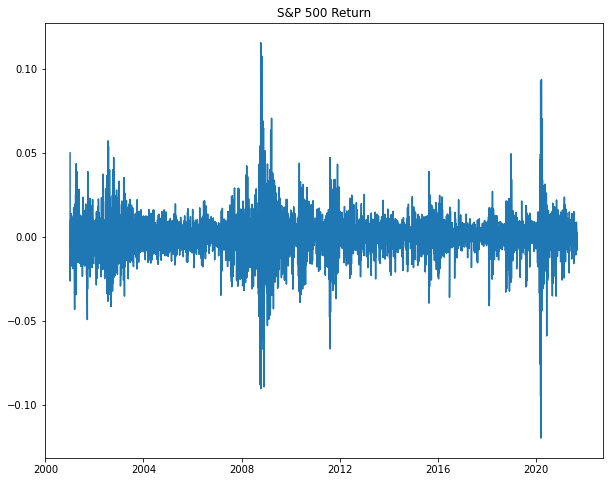

In [79]:
# Load 5-year S&P 500 Historical Prices and get daily excess return
#SPX = pd.read_csv('HistoricalPrices.csv', index_col=0, parse_dates=True) #Data contains info from Aug 16 to Aug 21
SPX = pd.read_csv('SPX.csv', index_col=0, parse_dates=True) #Data that contains info from Jan 01 to Sept 21
#SPX=SPX[::-1]
SPX_rtn=(np.divide(SPX[1:], SPX[:-1]) - 1).dropna()
plt.plot(SPX_rtn)
plt.title('S&P 500 Return')

In [80]:
# Stationarity Check
adfuller(SPX_rtn)

(-13.483035268186086,
 3.2135126667336296e-25,
 33,
 5171,
 {'1%': -3.4316152386678156,
  '5%': -2.8620991027450327,
  '10%': -2.5670676103697185},
 -30933.63240291297)

In [81]:
#Fit the model
mod_kns = sm.tsa.MarkovRegression(SPX_rtn, k_regimes=2,trend='nc',switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Markov Switching Model Results 
 
 Dep. Variable: Close No. Observations: 5205 
 
 
 Model: MarkovRegression Log Likelihood 16688.107 
 
 
 Date: Fri, 24 Sep 2021 AIC -33368.214 
 
 
 Time: 02:43:05 BIC -33341.984 
 
 
 Sample: 0 HQIC -33359.039 
 
 
 - 5205 
 
 
 Covariance Type: approx 
 
 
 
 Regime 0 parameters 
 
 coef std err z P>|z| [0.025 0.975] 
 
 
 sigma2 4.907e-05 1.7e-06 28.895 0.000 4.57e-05 5.24e-05 
 
 
 
 Regime 1 parameters 
 
 coef std err z P>|z| [0.025 0.975] 
 
 
 sigma2 0.0004 2.06e-05 20.773 0.000 0.000 0.000 
 
 
 
 Regime transition parameters 
 
 coef std err z P>|z| [0.025 0.975] 
 
 
 p[0->0] 0.9890 0.002 434.312 0.000 0.985 0.994 
 
 
 p[1->0] 0.0290 0.006 4.752 0.000 0.017 0.041 
 
 Warnings: [1] Covariance matrix calculated using numerical (complex-step) differentiation.

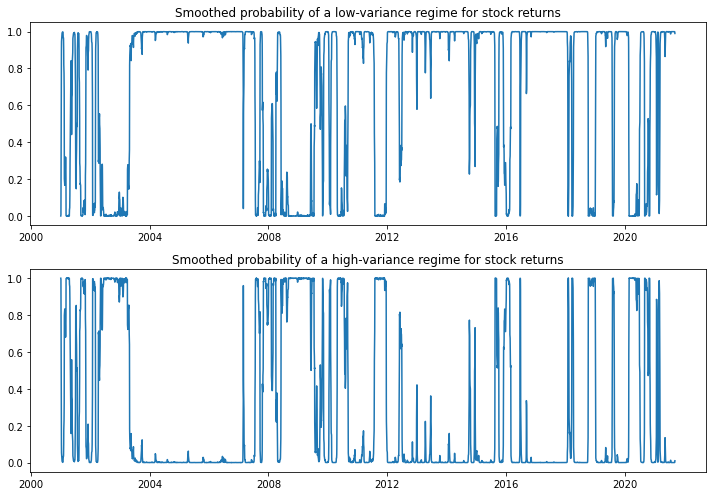

In [82]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

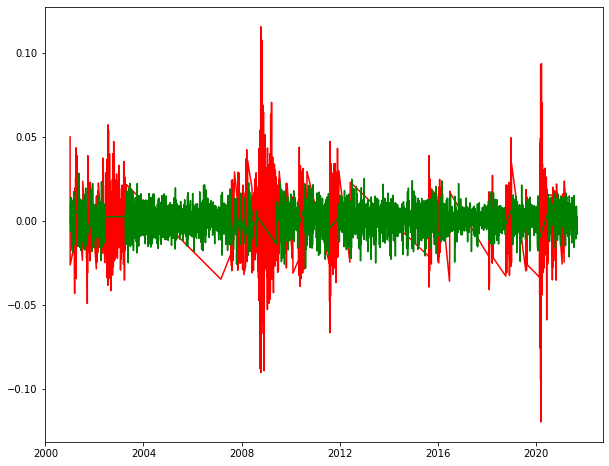

In [83]:
mask = res_kns.smoothed_marginal_probabilities[1] > 0.8
plt.plot(SPX_rtn[mask],'r')
plt.plot(SPX_rtn[-mask],'g')

As we can tell from the graph, Markov Autoregressive Model did a great job separating high-vol and low-vol equity market regimes.

In [84]:
# Triangular moving average to identify bullish and bearish regimes

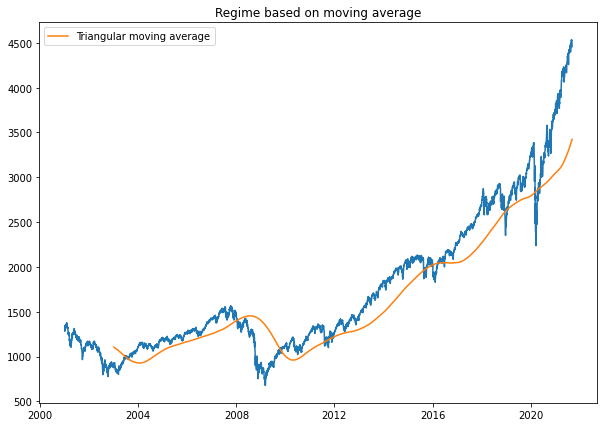

In [85]:

def moving_average(Data, lookback): 
    #Data must be a numpy array
    ma=[]
    for i in range(lookback,len(Data)):
        ma=np.append(ma,np.mean(Data[i-lookback:i-1]))
    return ma


Data=SPX['Close']
lookback=250

ma=moving_average(Data,lookback)
ma=pd.DataFrame(ma,index=SPX.index[lookback:])
triangular_ma = moving_average(ma, lookback)
triangular_ma=pd.DataFrame(triangular_ma,index=SPX.index[lookback*2:])
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(SPX['Close'])
#plt.plot(ma)
plt.plot(triangular_ma,label='Triangular moving average')
plt.title('Regime based on moving average')
plt.legend()

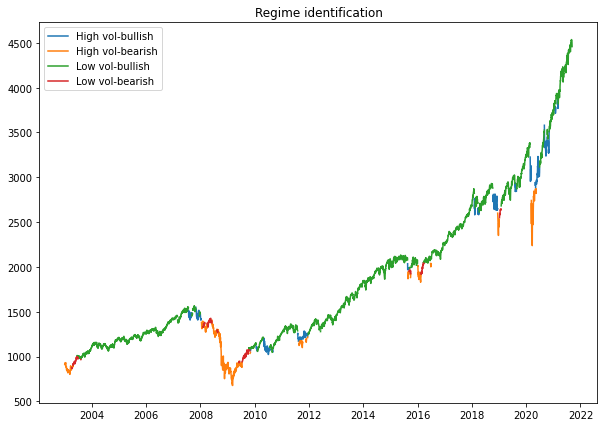

In [86]:
triangular_ma.columns=['MA']
SPX=SPX.iloc[1:]
regimes=pd.DataFrame(SPX['Close'])
aux=pd.merge(SPX,triangular_ma,on='Date',how='outer')#.fillna(0)
#Create Data Frames
regimes['High vol']=SPX[SPX[mask]>.8]
regimes['Low vol']=SPX[SPX[-mask]>.8]
regimes['Bullish']=SPX[aux['MA']<aux['Close']]
regimes['Bearish']=SPX[aux['MA']>aux['Close']]
regimes['High vol-bullish']=np.divide(np.multiply(regimes['High vol'],regimes['Bullish']),regimes['Close'])
regimes['High vol-bearish']=np.divide(np.multiply(regimes['High vol'],regimes['Bearish']),regimes['Close'])
regimes['Low vol-bullish']=np.divide(np.multiply(regimes['Low vol'],regimes['Bullish']),regimes['Close'])
regimes['Low vol-bearish']=np.divide(np.multiply(regimes['Low vol'],regimes['Bearish']),regimes['Close'])


plt.plot(regimes['High vol-bullish'],label='High vol-bullish')
plt.plot(regimes['High vol-bearish'],label='High vol-bearish')
plt.plot(regimes['Low vol-bullish'],label='Low vol-bullish')
plt.plot(regimes['Low vol-bearish'],label='Low vol-bearish')
plt.title('Regime identification')
plt.legend()

# Preprocessing of macroeconomic factors as features to predict regime shift

Used returns of ETF data that are highly correlated with the macro economy since most macroeconomic data are produced monthly. 

### 20-day realized volatility of S&P 500

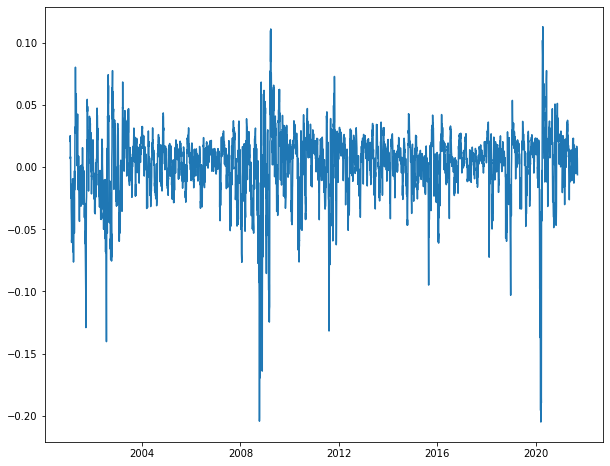

In [134]:
# daily deviation using 20-day moving average
rv = pd.DataFrame((SPX['Close']/SPX['Close'].rolling(20).mean()-1).dropna())
rv.columns = ['SPX']
plt.plot(rv)

### Commodity ETF

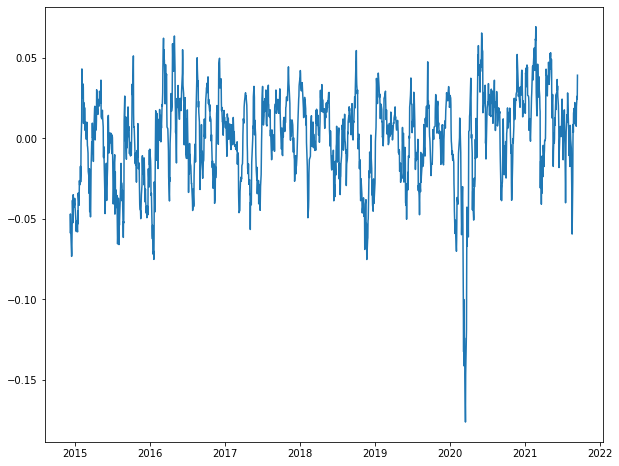

In [144]:
comm = pd.read_csv('PDBC.csv', index_col=0, parse_dates=True)['Adj Close']
comm = pd.DataFrame((comm/comm.rolling(20).mean()-1).dropna())
comm.columns = ['commodity']
plt.plot(comm)

### semiconductor ETF

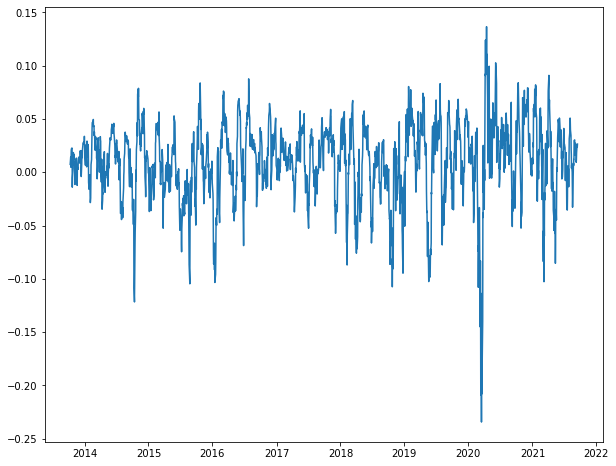

In [135]:
semicon = pd.read_csv('SOXX.csv', index_col=0, parse_dates=True)['Adj Close']
semicon = pd.DataFrame((semicon/semicon.rolling(20).mean()-1).dropna())
semicon.columns = ['semi conductor']
plt.plot(semicon)

### TIPS ETF for inflation

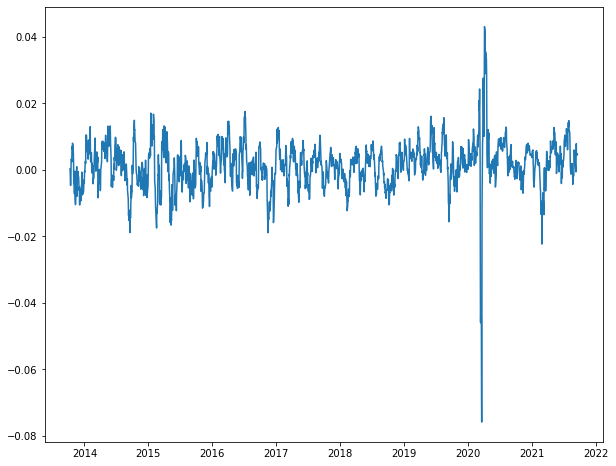

In [145]:
tips = pd.read_csv('TIP.csv', index_col=0, parse_dates=True)['Adj Close']
tips = pd.DataFrame((tips/tips.rolling(20).mean()-1).dropna())
tips.columns = ['TIPS']
plt.plot(tips)

### U.S unemployment rate

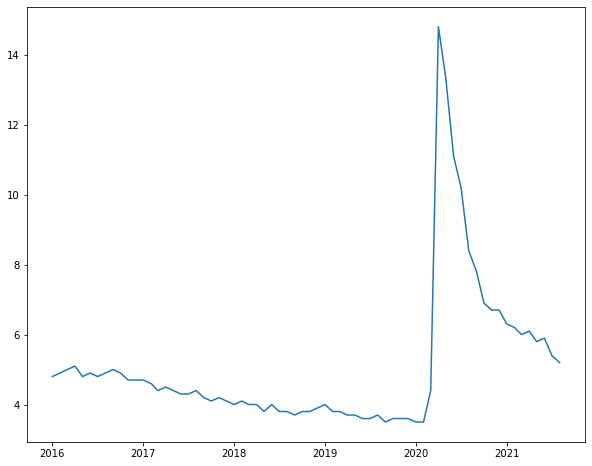

In [136]:
# monthly unemployment rate in U.S.
unemployment = pd.read_csv('us-national-unemployment-rate.csv', index_col=0, parse_dates=True)
unemployment.columns = ['Unemployment Rate']
plt.plot(unemployment)

In [137]:
# resample the data for daily unemployment rate
unemployment = unemployment.resample('D').asfreq().pad()

### Volatility Index

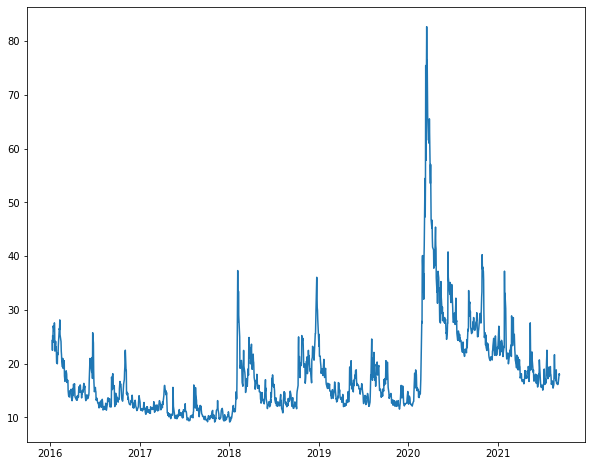

In [138]:
# Volatility Index
VIX = pd.DataFrame(pd.read_csv('^VIX.csv', index_col=0, parse_dates=True)['Adj Close'])
#VIX=VIX[::-1]
VIX.columns = ['VIX']
plt.plot(VIX)

### Fed Funds Interest Rate

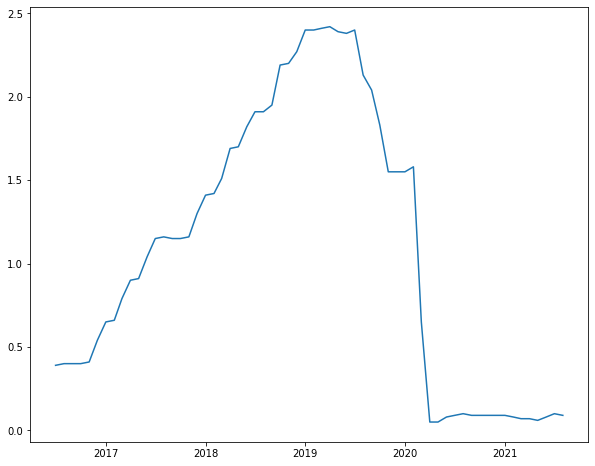

In [139]:
FED = pd.read_csv('FEDFUNDS.csv', index_col=0, parse_dates=True)
plt.plot(FED)
FED.columns = ['Interest Rate']
FED = FED.resample('D').asfreq().pad()

### GDP

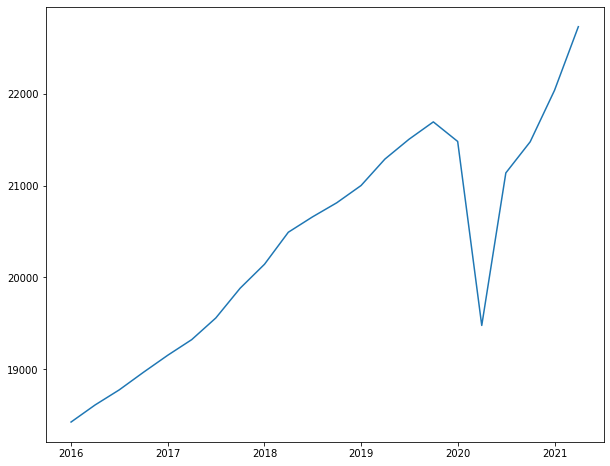

In [140]:
GDP = pd.read_csv('GDP.csv', index_col=0, parse_dates=True)
plt.plot(GDP)
GDP.columns = ['GDP']
GDP = GDP.resample('D').asfreq().pad()

## housing ETF

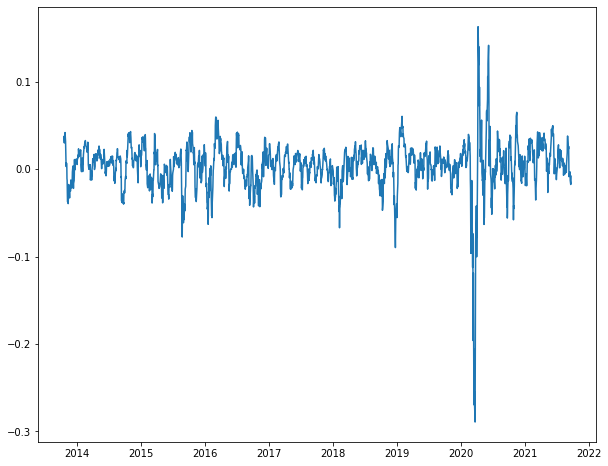

In [126]:
house = pd.read_csv('IYR.csv', index_col=0, parse_dates=True)['Adj Close']
house = pd.DataFrame((house/house.rolling(20).mean()-1).dropna())
house.columns = ['house']
plt.plot(house)

## ICE Swap Rates

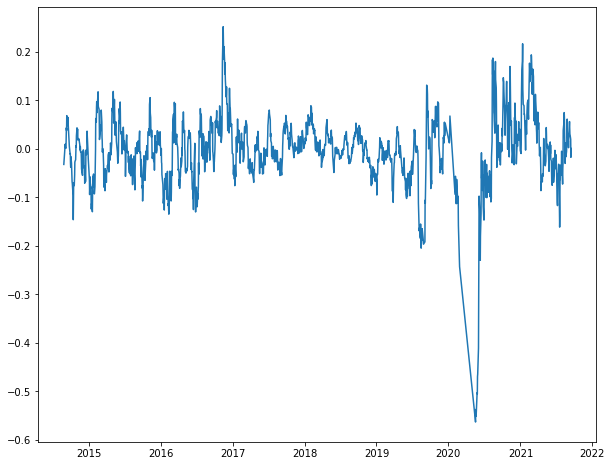

In [127]:
# ICE swap rates
swap = pd.read_csv('SwapRates.csv', index_col=0, parse_dates=True)
swap = pd.DataFrame((swap/swap.rolling(20).mean()-1).dropna())
swap.columns = ['Swap Rates']
plt.plot(swap)

### Feature Dataframe

In [146]:
# last five days' data of daily features

rv_VIX = rv.join(VIX).join(comm).join(semicon).join(tips).join(swap).join(house)
#rv_VIX = rv.join(VIX).join(comm).join(semicon).join(swap).join(house)
X = rv_VIX.copy()

for i in np.arange(1,5):
    temp = rv_VIX.shift(i).dropna()
    temp.columns = [j + '-{}'.format(i) for j in temp.columns]
    X = X.join(temp)
    

# combine all the input features

X = X.join(unemployment).join(FED).join(GDP)
#X = X.join(unemployment).join(GDP)
# Shift up to avoid using future data

X = X.shift(1)#.dropna()
X.fillna(method="ffill",inplace=True)
X.dropna(inplace = True)
X.head()

,SPX,VIX,commodity,semi conductor,TIPS,Swap Rates,house,SPX-1,VIX-1,commodity-1,...,SPX-4,VIX-4,commodity-4,semi conductor-4,TIPS-4,Swap Rates-4,house-4,Unemployment Rate,Interest Rate,GDP
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-05,0.009945,14.77,0.017703,-0.010509,0.015751,-0.078686,0.037890,0.008073,15.63,0.006034,...,-0.041356,23.850000,-0.012472,-0.068832,0.007438,-0.129900,0.002259,4.8,0.39,18775.459
2016-07-06,0.003532,15.58,-0.012471,-0.026506,0.016268,-0.119120,0.042420,0.009945,14.77,0.017703,...,-0.022895,18.750000,0.001132,-0.042231,0.009850,-0.121239,0.022137,4.8,0.39,18775.459
2016-07-07,0.009205,14.96,-0.006477,-0.022686,0.017576,-0.108482,0.035775,0.003532,15.58,-0.012471,...,-0.005571,16.639999,0.012143,-0.021301,0.008142,-0.108580,0.032677,4.8,0.39,18775.459
2016-07-08,0.008840,14.76,-0.033606,-0.008832,0.014608,-0.091761,0.024528,0.009205,14.96,-0.006477,...,0.008073,15.630000,0.006034,-0.003683,0.009020,-0.084158,0.041323,4.8,0.39,18775.459
2016-07-11,0.023873,13.20,-0.019131,0.019422,0.015869,-0.103714,0.036831,0.008840,14.76,-0.033606,...,0.009945,14.770000,0.017703,-0.010509,0.015751,-0.078686,0.037890,4.8,0.39,18775.459


# XGBoost Model for Regime Prediction

pip install xgboost

pip install --upgrade xgboost

In [112]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [170]:
# predictive outcome
# 0 - low-vol + bearish
# 1 - low-vol + bullish
# 2 - high-vol + bearish
# 3 - high-vol + bullish

y = pd.DataFrame()
for i in range(regimes.shape[0]):
    if not(math.isnan(regimes.iloc[i,-1])):
        y = y.append([[regimes.index.values[i],0]])
        continue
    if not(math.isnan(regimes.iloc[i,-2])):
        y = y.append([[regimes.index.values[i],1]])
        continue
    if not(math.isnan(regimes.iloc[i,-3])):
        y = y.append([[regimes.index.values[i],2]])
        continue
    if not(math.isnan(regimes.iloc[i,-4])):
        y = y.append([[regimes.index.values[i],3]])
        continue
y.columns = ['Date','y']
y.set_index(['Date'], inplace = True)

In [171]:
data = X.copy()
data = data.join(y)
data.head()

,SPX,VIX,commodity,semi conductor,TIPS,Swap Rates,house,SPX-1,VIX-1,commodity-1,...,VIX-4,commodity-4,semi conductor-4,TIPS-4,Swap Rates-4,house-4,Unemployment Rate,Interest Rate,GDP,y
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-05,0.009945,14.77,0.017703,-0.010509,0.015751,-0.078686,0.037890,0.008073,15.63,0.006034,...,23.850000,-0.012472,-0.068832,0.007438,-0.129900,0.002259,4.8,0.39,18775.459,1
2016-07-06,0.003532,15.58,-0.012471,-0.026506,0.016268,-0.119120,0.042420,0.009945,14.77,0.017703,...,18.750000,0.001132,-0.042231,0.009850,-0.121239,0.022137,4.8,0.39,18775.459,1
2016-07-07,0.009205,14.96,-0.006477,-0.022686,0.017576,-0.108482,0.035775,0.003532,15.58,-0.012471,...,16.639999,0.012143,-0.021301,0.008142,-0.108580,0.032677,4.8,0.39,18775.459,1
2016-07-08,0.008840,14.76,-0.033606,-0.008832,0.014608,-0.091761,0.024528,0.009205,14.96,-0.006477,...,15.630000,0.006034,-0.003683,0.009020,-0.084158,0.041323,4.8,0.39,18775.459,1
2016-07-11,0.023873,13.20,-0.019131,0.019422,0.015869,-0.103714,0.036831,0.008840,14.76,-0.033606,...,14.770000,0.017703,-0.010509,0.015751,-0.078686,0.037890,4.8,0.39,18775.459,1


In [172]:
# split data into train and test sets
# test_size = 0.3
# X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['y']), data['y'], test_size=test_size)
test_size = 0.3
sp = round(data.shape[0]*(1-test_size))
X_train = data.drop(columns = ['y']).iloc[:sp,:]
X_test = data.drop(columns = ['y']).iloc[sp:,:]
y_train = data['y'].iloc[:sp]
y_test = data['y'].iloc[sp:]

In [173]:
# fit model no training data
model = XGBClassifier(max_depth=8, gamma=1,min_child_weight=2)
model.fit(X_train, y_train)

[04:08:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/python/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [174]:

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

/opt/python/envs/default/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [175]:

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.94%


In [176]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

   Next step
   1. Trading strategies
   2. 4 market regimes

## pre-COVID period

In [284]:
pos1 = data.index.get_loc('2020-03-02')
#pos2 = data.index.get_loc('2021-04-01')
#data_pre_covid = pd.concat([data.iloc[:pos1,:],data.iloc[pos2:,:]])
data_pre_covid = data.iloc[:pos1,:]
# split data into train and test sets
# test_size = 0.3
# X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['y']), data['y'], test_size=test_size)
test_size = 0.3
sp = round(data_pre_covid.shape[0]*(1-test_size))
X_train = data_pre_covid.drop(columns = ['y']).iloc[:sp,:]
X_test = data_pre_covid.drop(columns = ['y']).iloc[sp:,:]
y_train = data_pre_covid['y'].iloc[:sp]
y_test = data_pre_covid['y'].iloc[sp:]

In [285]:

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

[04:49:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/python/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [286]:

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

/opt/python/envs/default/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [287]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.16%


In [155]:
# accuracy for high-vol market regimes
msk = y_test == 1
(y_test[msk] == np.array(predictions)[msk]).sum()/len(y_test[msk])

0.21323529411764705

# LSTM

In [35]:
pip install keras

     |████████████████████████████████| 1.3 MB 30.1 MB/s 
You should consider upgrading via the '/opt/python/envs/default/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [36]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [37]:
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding

from tensorflow.python.keras.models import Sequential

In [2]:
!pip3 install yfinance
import yfinance as yf

  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23908 sha256=23931a5e96386d661ca44bd407db2c841fc298e0ca0be772cb7dc685947b5e23
  Stored in directory: /home/datalore/.cache/pip/wheels/ec/cc/c1/32da8ee853d742d5d7cbd11ee04421222eb354672020b57297
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8367 sha256=0bf307ce42fa12272e69416a551cc0dbf711f01aad5444c15cf41f8371c5e628
  Stored in directory: /home/datalore/.cache/pip/wheels/57/6d/a3/a39b839cc75274d2acfb1c58bfead2f726c6577fe8c4723f13
Successfully built yfinance multitasking
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


[*********************100%***********************]  1 of 1 completed


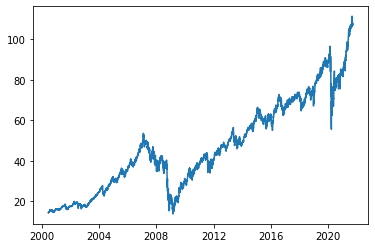

In [18]:
#daily housing etf: iShares U.S. Real Estate ETF
#starting from 2000 June
#https://etfdb.com/etfdb-category/real-estate/
tickers = ['IYR'] 
tickers = pd.DataFrame(tickers)
tickers = tickers.T
tickers.columns = tickers.iloc[0]

def get_prices(ticker):
    data = yf.download(ticker, start="2000-01-01", end="2021-09-20")
    return data['Adj Close']

prices = []
for i in range(0,1):
    prices.append(get_prices(tickers.iloc[0,i]))

df_prices = pd.DataFrame(prices).T
df_prices.columns = tickers.columns
#df_prices.head()
plt.plot(df_prices)

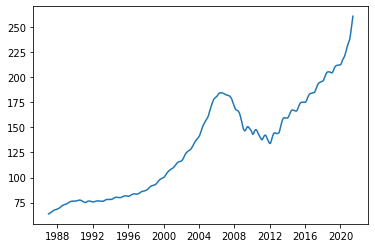

In [12]:
#monthly S&P/Case-Shiller U.S. National Home Price Index
#FRED
homeprice = pd.read_csv('CSUSHPINSA.csv', index_col=0, parse_dates=True)
plt.plot(homeprice)

[*********************100%***********************]  1 of 1 completed


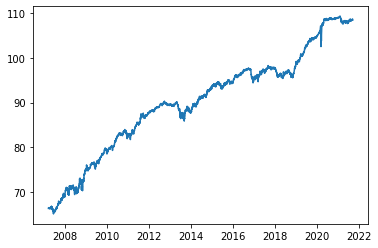

In [27]:
#daily mbs etf: Vanguard Mortgage-Backed Securities Index Fund ETF Shares 
#starting from 2009 Nov

tickers = ['MBB'] 
tickers = pd.DataFrame(tickers)
tickers = tickers.T
tickers.columns = tickers.iloc[0]

def get_prices(ticker):
    data = yf.download(ticker, start="2000-01-01", end="2021-09-20")
    return data['Adj Close']

prices = []
for i in range(0,1):
    prices.append(get_prices(tickers.iloc[0,i]))

df_prices = pd.DataFrame(prices).T
df_prices.columns = tickers.columns
df_prices.head()
plt.plot(df_prices)

## Investment Strategy

In [87]:
prices = pd.read_csv('Asset Data.csv', index_col=0, parse_dates=True)

<ipython-input-303-56daeb1e7305>:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  regime_returns = (np.divide(regimes.iloc[1:,:],regimes.iloc[:-1,:])-1)
<ipython-input-303-56daeb1e7305>:2: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.a

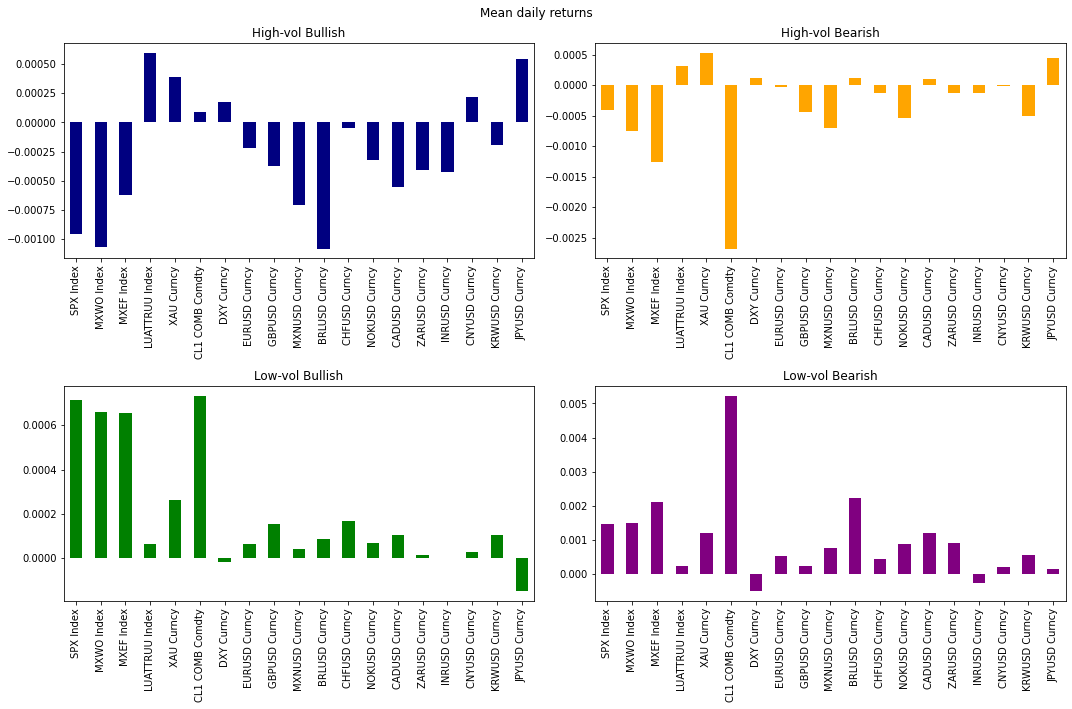

In [303]:
regime_returns = (np.divide(regimes.iloc[1:,:],regimes.iloc[:-1,:])-1)
asset_returns=np.divide(prices.iloc[1:,:],prices.iloc[:-1,:])-1

hv_bullish_returns=pd.merge(regime_returns['High vol-bullish'],asset_returns,on='Date',how='inner').dropna()
hv_bearish_returns=pd.merge(regime_returns['High vol-bearish'],asset_returns,on='Date',how='inner').dropna()
lv_bullish_returns=pd.merge(regime_returns['Low vol-bullish'],asset_returns,on='Date',how='inner').dropna()
lv_bearish_returns=pd.merge(regime_returns['Low vol-bearish'],asset_returns,on='Date',how='inner').dropna()

hv_bullish_returns=hv_bullish_returns.iloc[:,1:]
hv_bearish_returns=hv_bearish_returns.iloc[:,1:]
lv_bullish_returns=lv_bullish_returns.iloc[:,1:]
lv_bearish_returns=lv_bearish_returns.iloc[:,1:]
bm_returns = asset_returns

mean_hv_bullish=hv_bullish_returns.mean(axis=0)
mean_hv_bearish=hv_bearish_returns.mean(axis=0)
mean_lv_bullish=lv_bullish_returns.mean(axis=0)
mean_lv_bearish=lv_bearish_returns.mean(axis=0)

plt.rcParams["figure.figsize"] = (15,10)
plt.subplot(2, 2, 1)
mean_hv_bullish.plot(kind="bar",color='navy',title='High-vol Bullish')
plt.subplot(2, 2, 2)
mean_hv_bearish.plot(kind="bar",color='orange',title='High-vol Bearish')
plt.subplot(2, 2, 3)
mean_lv_bullish.plot(kind="bar",color='green',title='Low-vol Bullish')
plt.subplot(2,2, 4)
mean_lv_bearish.plot(kind="bar",color='purple',title='Low-vol Bearish')
plt.suptitle('Mean daily returns')
plt.tight_layout()

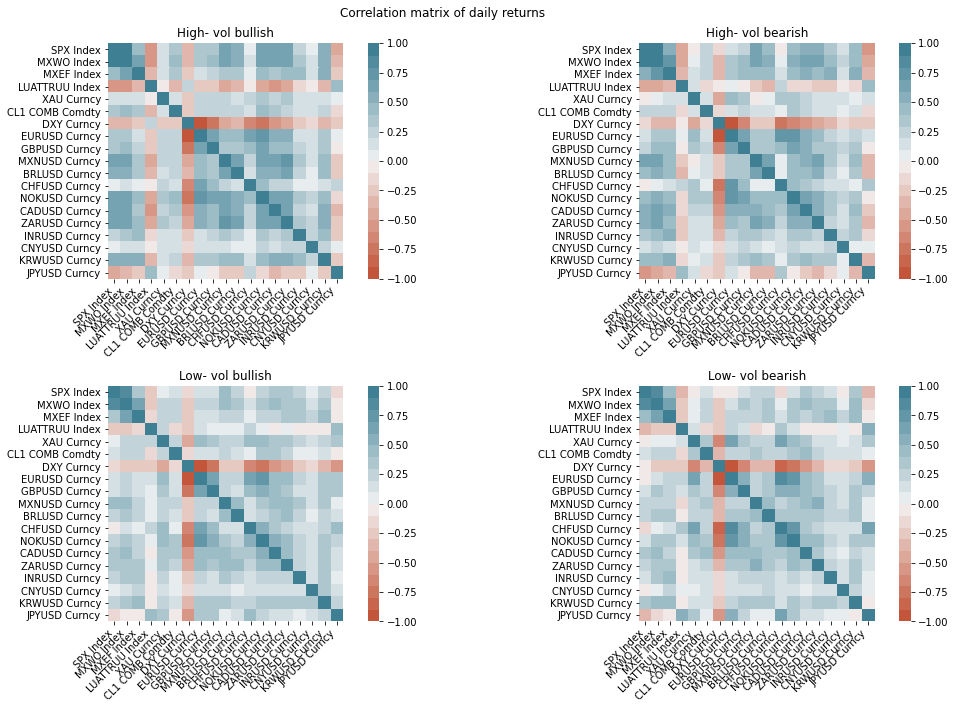

In [299]:
# Correlation matrices
import seaborn as sns

corr_hv_bullish=hv_bullish_returns.corr()
corr_hv_bearish=hv_bearish_returns.corr()
corr_lv_bullish=lv_bullish_returns.corr()
corr_lv_bearish=lv_bearish_returns.corr()
plt.subplot(2, 2, 1)
ax = sns.heatmap(corr_hv_bullish, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=20),square=True)
ax.set_title('High- vol bullish')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.subplot(2, 2, 2)
ax = sns.heatmap(corr_hv_bearish, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=20),square=True)
ax.set_title('High- vol bearish')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.subplot(2, 2, 3)
ax = sns.heatmap(corr_lv_bullish, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=20),square=True)
ax.set_title('Low- vol bullish')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.subplot(2, 2, 4)
ax = sns.heatmap(corr_lv_bearish, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=20),square=True)
ax.set_title('Low- vol bearish')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.suptitle('Correlation matrix of daily returns')
plt.tight_layout()

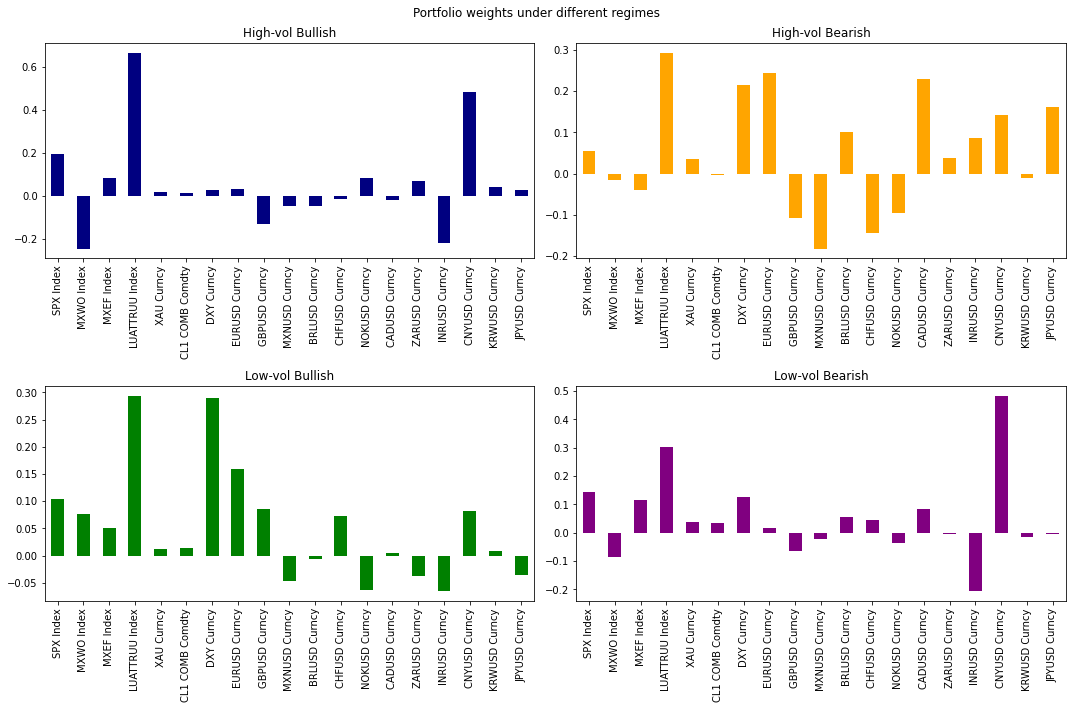

In [304]:
## Portfolio optimization
from scipy.optimize import minimize

def portfolio_optimizer(returns):
    mu=returns.mean()
    def objective(weights): 
        weights = np.array(weights)
        ret_port= np.matmul(weights.T,mu.values)
        var_port=  weights.dot(returns.cov()).dot(weights.T)
        return -ret_port/math.sqrt(var_port) 

    # Impose constaint that weights must sum 1
    cons = ({"type":"eq", "fun": lambda x: np.sum(x)-1}) 
    # Add constraint of no short-selling more than 50%
    bounds = tuple((-1,1) for x in range(returns.shape[1])) 

    # Initialize the weights 
    guess = [1./returns.shape[1] for x in range(returns.shape[1])]
    opt_port = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
    portfolio=pd.DataFrame(opt_port.x,columns=['Weight'],index=mu.index)
    return portfolio

#Optimize for all portfolios
hv_bullish_port=portfolio_optimizer(hv_bullish_returns)
hv_bearish_port=portfolio_optimizer(hv_bearish_returns)
lv_bullish_port=portfolio_optimizer(lv_bullish_returns)
lv_bearish_port=portfolio_optimizer(lv_bearish_returns)
bm_port = portfolio_optimizer(bm_returns)

plt.rcParams["figure.figsize"] = (15,10)
plt.subplot(2, 2, 1)
hv_bullish_port['Weight'].plot(kind="bar",color='navy',title='High-vol Bullish')
plt.subplot(2, 2, 2)
hv_bearish_port['Weight'].plot(kind="bar",color='orange',title='High-vol Bearish')
plt.subplot(2, 2, 3)
lv_bullish_port['Weight'].plot(kind="bar",color='green',title='Low-vol Bullish')
plt.subplot(2,2, 4)
lv_bearish_port['Weight'].plot(kind="bar",color='purple',title='Low-vol Bearish')
plt.suptitle('Portfolio weights under different regimes')
plt.tight_layout()

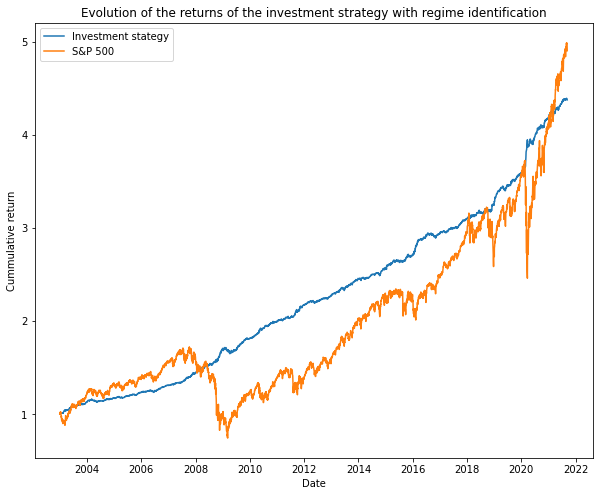

In [94]:
port_ret_hv_bullish= pd.DataFrame(np.sum(hv_bullish_port.T.values*hv_bullish_returns,axis=1),columns=['Port ret hv bullish'])
port_ret_hv_bearish= pd.DataFrame(np.sum(hv_bearish_port.T.values*hv_bearish_returns,axis=1),columns=['Port ret hv bearish'])
port_ret_lv_bullish= pd.DataFrame(np.sum(lv_bullish_port.T.values*lv_bullish_returns,axis=1),columns=['Port ret lv bullish'])
port_ret_lv_bearish= pd.DataFrame(np.sum(lv_bearish_port.T.values*lv_bearish_returns,axis=1),columns=['Port ret lv bearish'])

portfolio_returns = pd.merge(port_ret_hv_bullish,port_ret_hv_bearish,on='Date',how='outer')
portfolio_returns = pd.merge(portfolio_returns,port_ret_lv_bullish,on='Date',how='outer')
portfolio_returns = pd.merge(portfolio_returns,port_ret_lv_bearish,on='Date',how='outer')
portfolio_returns = portfolio_returns.sort_index()
portfolio_returns = portfolio_returns.fillna(0)
portfolio_returns = pd.DataFrame(np.sum(portfolio_returns,axis=1),columns=['Portfolio returns'])

aux=portfolio_returns+1
aux_1=SPX_rtn[SPX_rtn.index>='2003-01-03']
aux_1=(aux_1+1)
portfolio_cum_ret = aux.cumprod()

plt.rcParams["figure.figsize"] = (10,8)
plt.plot(portfolio_cum_ret,label='Investment stategy')
plt.plot(aux_1.cumprod(),label='S&P 500')
plt.title('Evolution of the returns of the investment strategy with regime identification')
plt.xlabel('Date')
plt.ylabel('Cummulative return')
plt.legend()

## Dynamic Strategy

In [294]:
class Strat:
    """
    Wrapper class for a given strategy
    
    Data Structure:
    data: dataframe of data
    fore: array of forecast

    """
    def __init__(self, data, fore):
        self.data = data
        self.fore = fore
        self.strats = []
        
    def add_strat(self, func):
        self.strats.append(func)
        print(str(func) + ' added to strategy list')
    
    def testall(self):
        unitret = pd.DataFrame(columns = ['Date']+['Ret' + str(ii) for ii in range(len(self.strats))])
        first = True
        cumret = pd.DataFrame(columns = ['Date']+['CumRet' + str(ii) for ii in range(len(self.strats))])
        for ii in range(self.data.shape[0]):
            ret = [self.data.index[ii]]
            cret = [self.data.index[ii]]
            for jj, res in enumerate(self.strats):
                ret.append(res(self.data.iloc[ii,:], self.fore[ii]))
                if first:
                    cret.append(res(self.data.iloc[ii,:], self.fore[ii]) + 1)
                else:
                    cret.append(cumret.iloc[-1, jj+1] * (1 + res(self.data.iloc[ii,:], self.fore[ii])))
            unitret.loc[ii] = ret
            cumret.loc[ii] = cret
            first = False
        self.ret = unitret
        self.cumret = cumret
    
    def printplot(self):
        plt.figure()
        for ind in range(len(self.strats)):
            plt.plot(np.array(self.cumret.Date), np.array(self.cumret['CumRet' + str(ind)]), label = "Strat " + str(ind + 1))
        plt.legend()
        plt.show()

    def printsharpe(self):
        for ii, st in enumerate(self.strats):
            print('Sharpe Ratio of ' + st.__name__ + ' is:' + str(np.mean(self.ret['Ret' + str(ii)])/np.std(self.ret['Ret' + str(ii)])))

In [264]:
def invstrat(slice, forecast):
    #Use the portfolio weights computed above to get the regime strategy return
    if forecast == 'HighBull':
        return float(np.dot(np.array(lv_bullish_port).T , np.array(slice).reshape((-1,1))))
    if forecast == 'LowBull':
        return float(np.dot(np.array(lv_bullish_port).T , np.array(slice).reshape((-1,1))))
    if forecast == 'HighBear':
        return float(np.dot(np.array(hv_bearish_port).T , np.array(slice).reshape((-1,1))))
    if forecast == 'LowBear':
        return float(np.dot(np.array(lv_bearish_port).T , np.array(slice).reshape((-1,1))))

In [210]:
def holdindex(slice, forecast):
    return slice[0]

In [301]:
def bm(slice, forecast):
    return float(np.dot(np.array(bm_port).T , np.array(slice).reshape((-1,1))))

In [206]:
def translate(x):
    ## x is an array of numeric forecast value where we translate them into texts
    ## predictive outcome
    # 0 - low-vol + bearish
    # 1 - low-vol + bullish
    # 2 - high-vol + bearish
    # 3 - high-vol + bullish
    temp = ['LowBear' if a == 0 else a for a in x]
    temp = ['LowBull' if a == 1 else a for a in temp]
    temp = ['HighBear' if a == 2 else a for a in temp]
    temp = ['HighBull' if a == 3 else a for a in temp]
    return temp

In [289]:
XGBSlice = asset_returns.loc[y_test.index]

In [308]:
XGBRes = Strat(XGBSlice, translate(y_pred))
XGBRes.add_strat(invstrat)
XGBRes.add_strat(bm)
XGBRes.testall()

<function invstrat at 0x7fc5fdca2160> added to strategy list
<function bm at 0x7fc5cfdd4e50> added to strategy list


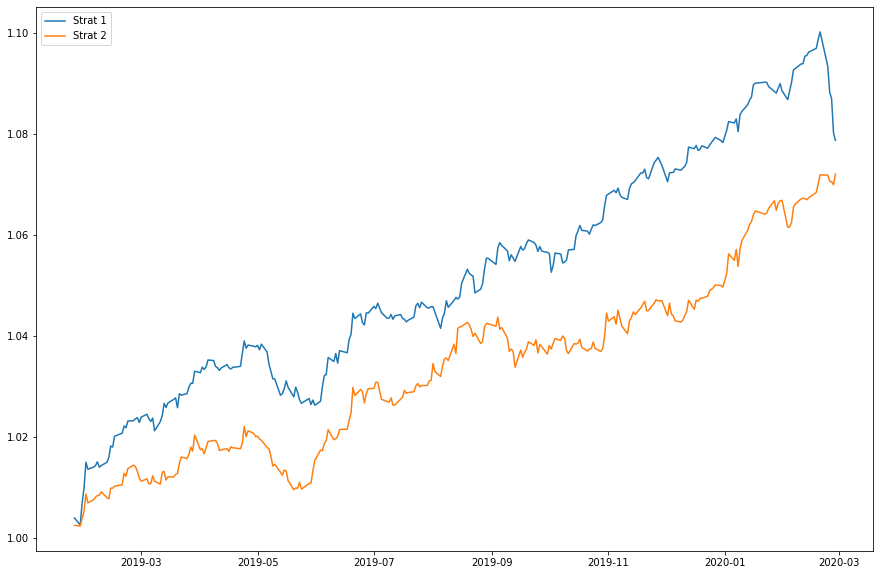

In [309]:
XGBRes.printplot()

In [310]:
XGBRes.printsharpe()

Sharpe Ratio of invstrat is:0.18733820478038016
Sharpe Ratio of bm is:0.17730777586746962


In [101]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping